In [5]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
from img_utils import *
path = "../nybolig-scrape/output_raw"
# path = "../nybolig-scrape/output/part_2"
houses_df = data_to_DF_old(path, max_houses=1000)

Errors encountered while loading houses:
[Errno 20] Not a directory: '../nybolig-scrape/output_raw/.DS_Store': 1 times


In [7]:
print(len(houses_df))

324


# 1. Data Exploration

In [10]:
from utils import prepare_features
display(houses_df.head(1))
#Remove url 
houses_df = houses_df.drop(columns=["url"])
houses_df_ = prepare_features(houses_df)
display(houses_df_.head(1))

,url,address,lattitude,longitude,postal_code,type,price,postal_avg_sqm_price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,https://danbolig.dk/bolig/gladsaxe/2860/lejlig...,Niels Finsens Alle 90 st.. tv. 2860 Søborg,55.7369662412981,12.5131171327647,2860,ejerlejlighed,1750000,0.0,40,None,2.0,1944.0,None,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


,lattitude,longitude,postal_code,price,postal_avg_sqm_price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,55.7369662412981,12.5131171327647,1.275739,1750000,0.0,-1.198961,0.0,-0.812926,-0.143432,-0.143432,0.112503,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Data description:


,postal_code,price,postal_avg_sqm_price,size,basement_size,rooms,year_built,year_rebuilt,energy_label
count,310.000000,3.100000e+02,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.000000
mean,0.010763,3.812490e+06,0.0,-0.078614,0.0,-0.056802,0.020811,0.020811,-0.005081
std,0.981421,2.194746e+06,0.0,0.829291,0.0,0.925498,0.998689,0.998689,1.015947
min,-2.952058,9.950000e+05,0.0,-1.389371,0.0,-1.732137,-6.502889,-6.502889,-2.491137
25%,-0.403796,2.495000e+06,0.0,-0.709336,0.0,-0.812926,-0.341546,-0.341546,0.112503
50%,-0.027349,3.145000e+06,0.0,-0.192509,0.0,0.106284,0.054682,0.054682,0.112503
75%,0.797940,4.498750e+06,0.0,0.351519,0.0,0.106284,0.545014,0.545014,0.633231
max,1.391569,1.225000e+07,0.0,4.159717,0.0,2.863914,1.461291,1.461291,2.195415


\begin{tabular}{lrrrrrrrrr}
\toprule
 & postal_code & price & postal_avg_sqm_price & size & basement_size & rooms & year_built & year_rebuilt & energy_label \\
\midrule
count & 310.000000 & 310.000000 & 310.000000 & 310.000000 & 310.000000 & 310.000000 & 310.000000 & 310.000000 & 310.000000 \\
mean & 0.010763 & 3812490.322581 & 0.000000 & -0.078614 & 0.000000 & -0.056802 & 0.020811 & 0.020811 & -0.005081 \\
std & 0.981421 & 2194745.699249 & 0.000000 & 0.829291 & 0.000000 & 0.925498 & 0.998689 & 0.998689 & 1.015947 \\
min & -2.952058 & 995000.000000 & 0.000000 & -1.389371 & 0.000000 & -1.732137 & -6.502889 & -6.502889 & -2.491137 \\
25% & -0.403796 & 2495000.000000 & 0.000000 & -0.709336 & 0.000000 & -0.812926 & -0.341546 & -0.341546 & 0.112503 \\
50% & -0.027349 & 3145000.000000 & 0.000000 & -0.192509 & 0.000000 & 0.106284 & 0.054682 & 0.054682 & 0.112503 \\
75% & 0.797940 & 4498750.000000 & 0.000000 & 0.351519 & 0.000000 & 0.106284 & 0.545014 & 0.545014 & 0.633231 \\
max & 1.391569 & 

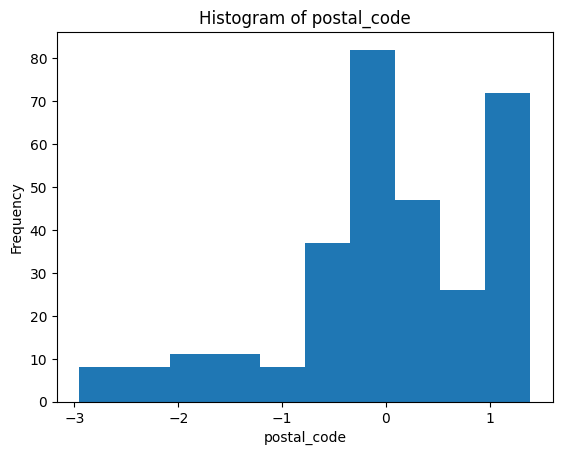

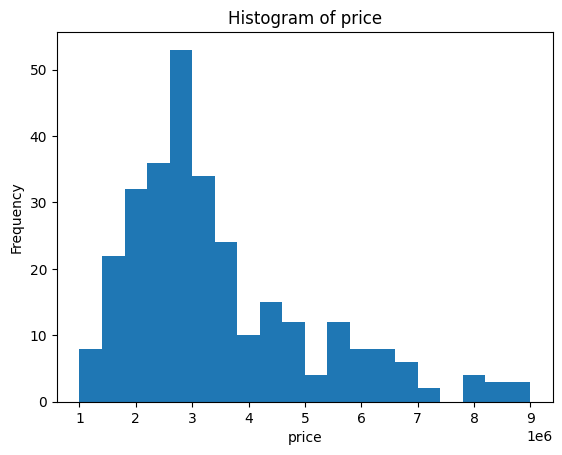

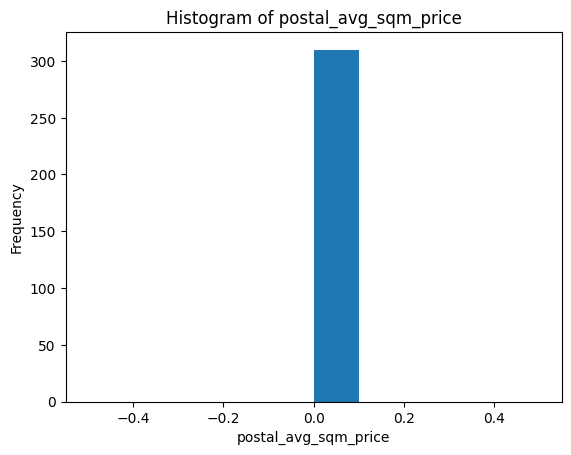

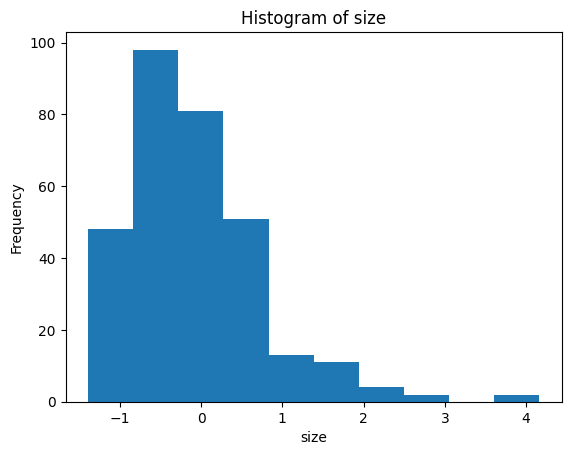

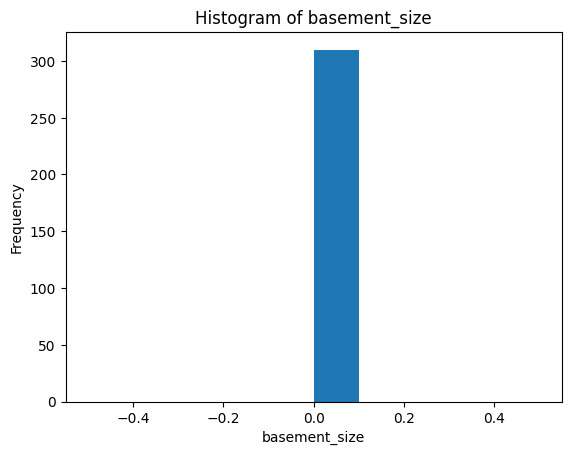

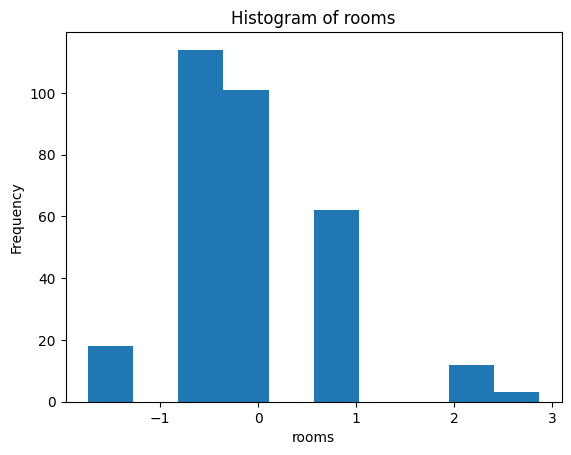

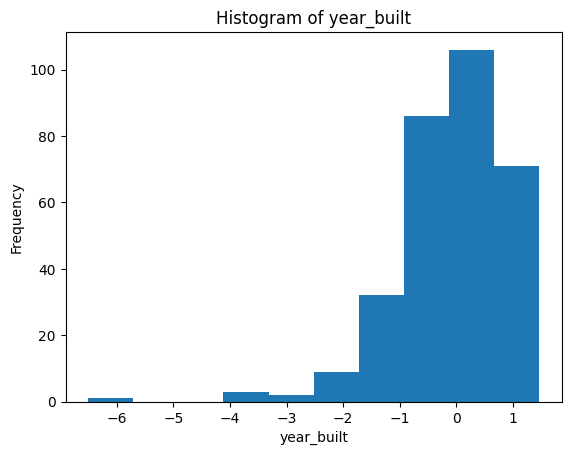

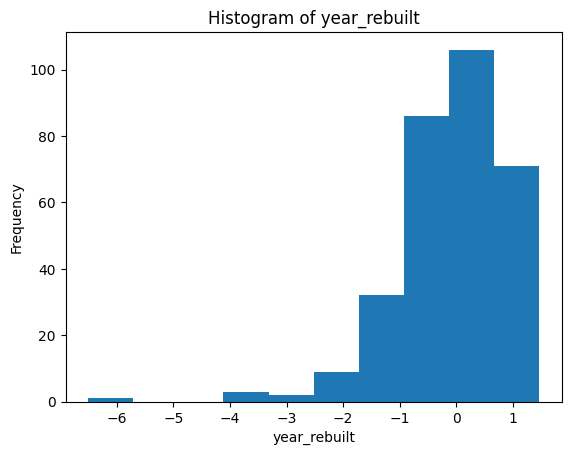

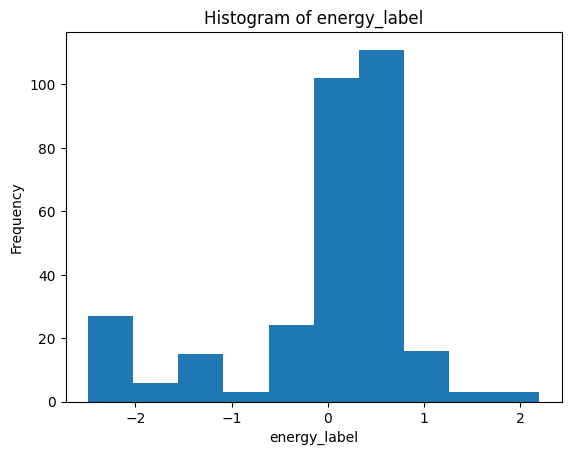

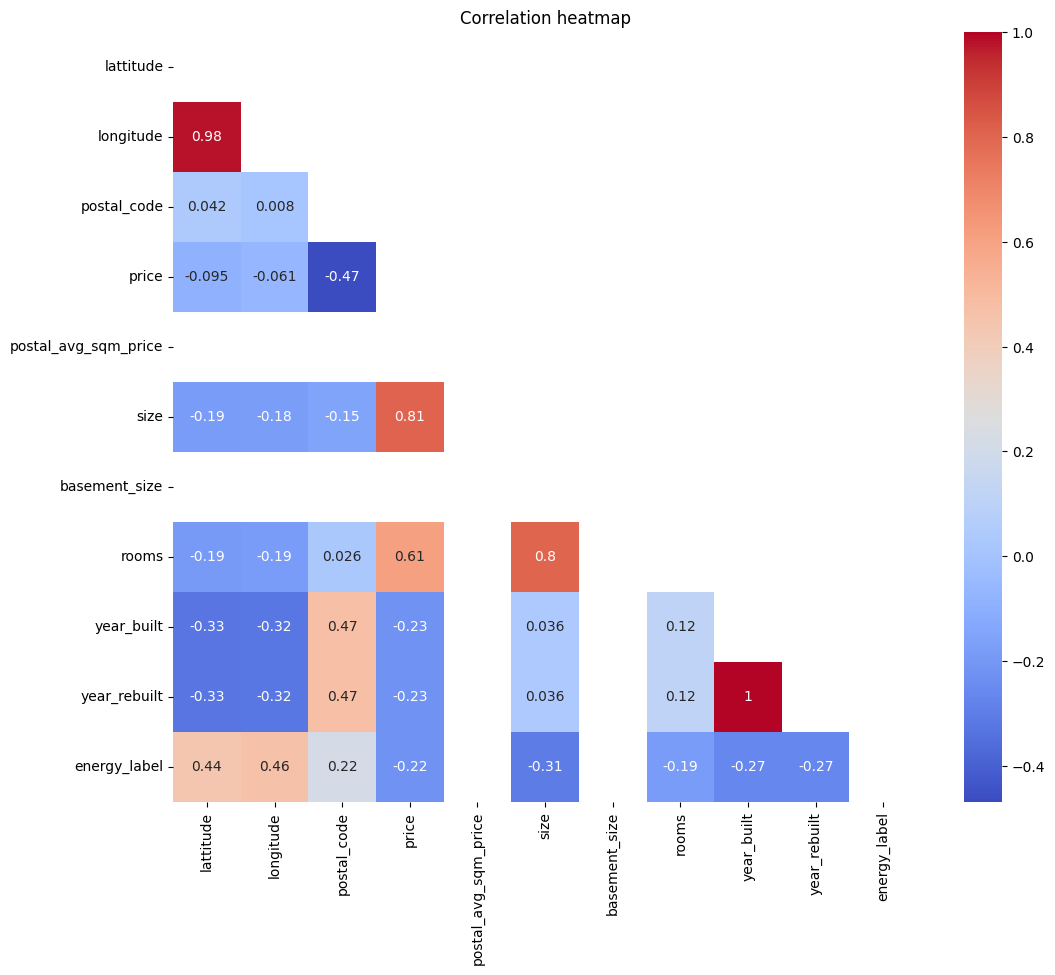

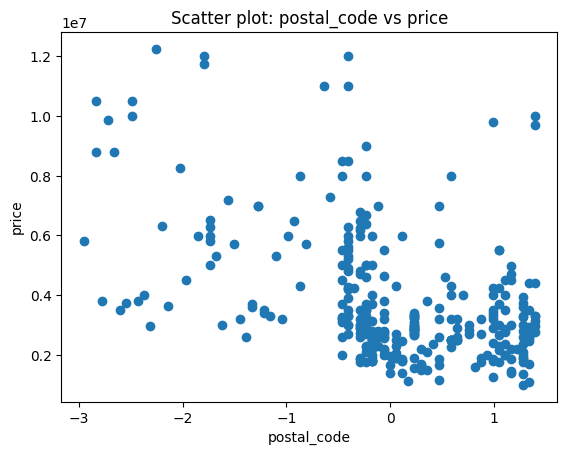

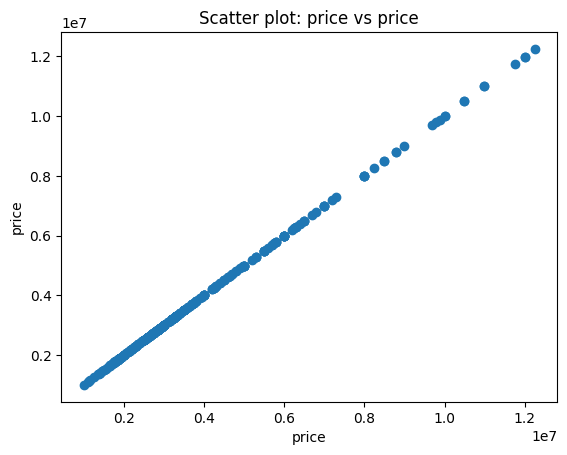

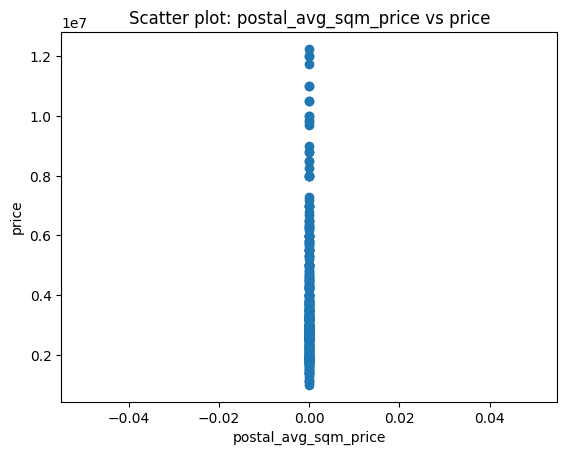

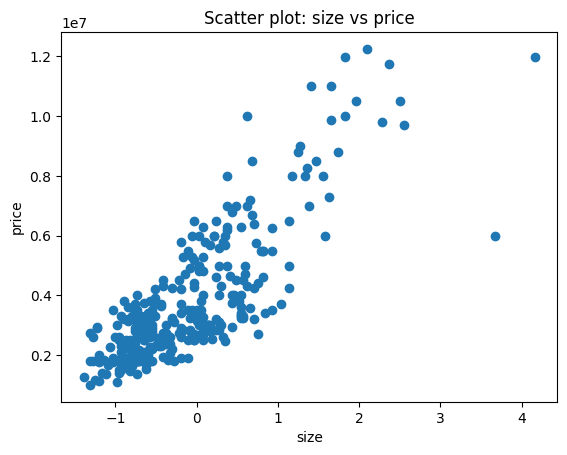

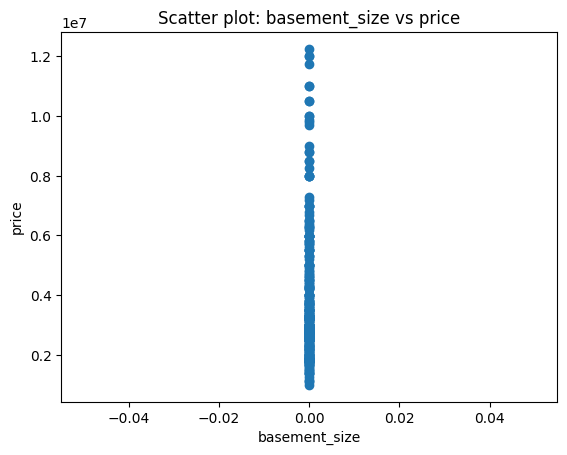

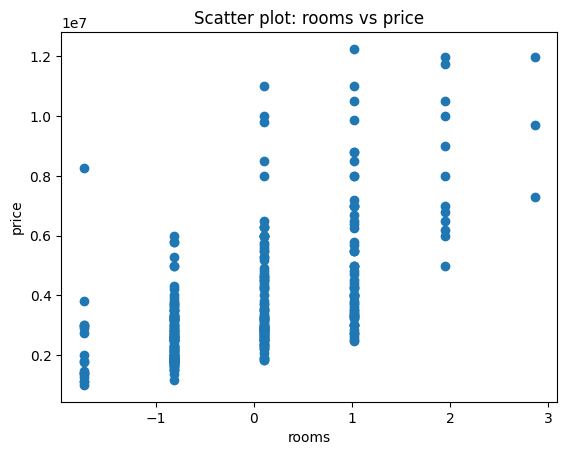

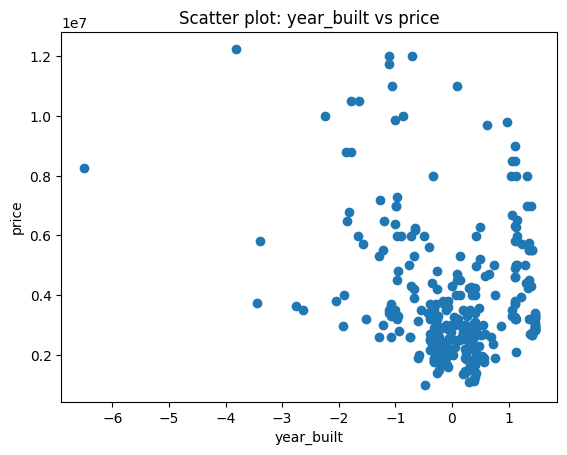

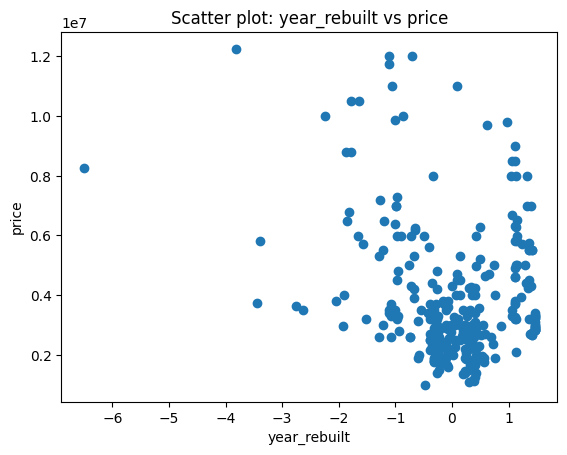

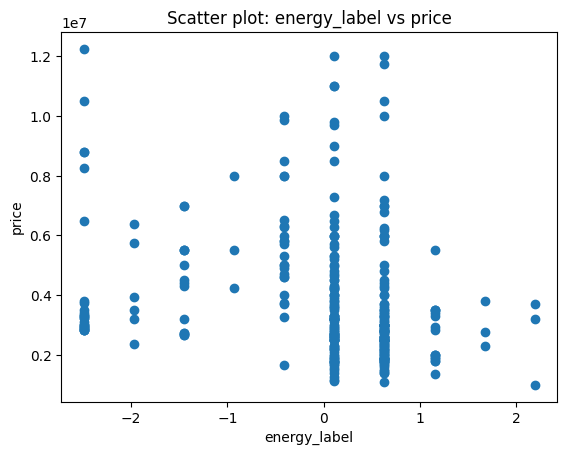

In [11]:
from DataExploration import full_summary
full_summary(houses_df_)

In [12]:
from img_utils import preprocess_images
train_images_448 = preprocess_images(
    houses_df_, "image_floorplan", 448, 448, True, False, False)

In [26]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
pretrained_model = VGG16
images = train_images_448

def CNN_model(
    # pretrained_model, custom_layers, train_images, y_train, validation_images, y_valid
    pretrained_model: object,
    custom_layers: bool,
    train_images: np.array,
    y_train: np.array,
    validation_images: np.array,
    y_valid: np.array,
):
    # Load the Pretrained Model
    target_width = train_images[0].shape[0]
    target_height = train_images[0].shape[1]
    input_shape = (target_width, target_height, 3)
    base_model = pretrained_model(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    # Freeze the pretrained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model with the pretrained model and a new classification layer
    if custom_layers:
        model = Sequential(
            [
                base_model,
                Flatten(),
                Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
                # BatchNormalization(),
                Dropout(0.1),
                Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
                Dropout(0.1),
                Dense(128, activation="relu"),
                Dense(64, activation="relu"),
                Dense(1, activation="linear"),
            ]
        )
    else:
        model = Sequential([base_model, Flatten(), Dense(1, activation="linear")])

    # Check which type of model we are building
    model.compile(
        optimizer="Adam", loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )
    return model

model = CNN_model(pretrained_model, custom_layers=True, train_images=images, y_train=houses_df_["price"], validation_images=images, y_valid=houses_df_["price"])


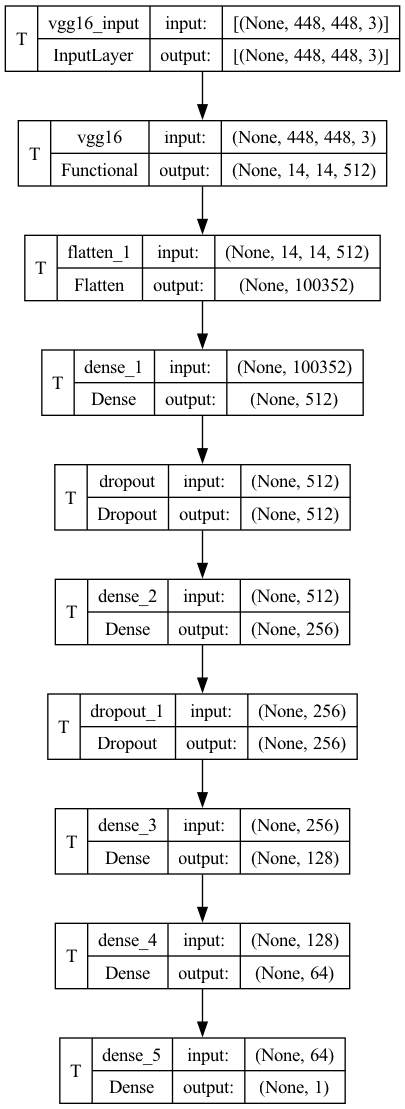

In [ ]:
#plot the model archetecture 
img = plot_model(model, to_file="VGG16_Architecture.png",
                 show_shapes=True, show_layer_names=True, show_trainable=False,
                 rankdir="TB", expand_nested=False, dpi=96)
#€plot the image
from IPython.display import Image
Image(filename="VGG16_Architecture.png")

